In [10]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import cmath


from finite_groups import *

from activation_funcs import *

In [11]:
# ==============================================================================
# HELPER: S4 DATA GENERATION
# ==============================================================================
def get_s4_data():
    """Generates S4 elements, classes, and characters for use in the main logic."""
    # 1. Elements
    perms = list(it.permutations(range(4)))
    
    # 2. Representatives & Classes (Manual definitions for standard S4)
    # 1A: Identity
    rep_1a = (0, 1, 2, 3) 
    # 2A: Transposition (0 1)
    rep_2a = (1, 0, 2, 3)
    # 3A: 3-Cycle (0 1 2)
    rep_3a = (1, 2, 0, 3)
    # 2B: Double Transposition (0 1)(2 3)
    rep_2b = (1, 0, 3, 2)
    # 4A: 4-Cycle (0 1 2 3)
    rep_4a = (1, 2, 3, 0)

    reps = [rep_1a, rep_2a, rep_3a, rep_2b, rep_4a]
    
    # 3. Character Table Rows (1, Sign, Deg2, Std, Std*Sign)
    # Cols: 1A, 2A, 3A, 2B, 4A
    chars = [
        [1,  1,  1,  1,  1], # Chi1 (Triv)
        [1, -1,  1,  1, -1], # Chi2 (Sign)
        [2,  0, -1,  2,  0], # Chi3 (Deg2)
        [3,  1,  0, -1, -1], # Chi4 (Std)
        [3, -1,  0, -1,  1]  # Chi5 (Std*Sign)
    ]
    
    return perms, reps, chars

# ==============================================================================
# SECTION 1: DEFINE GROUP (G = C2 x S4)
# ==============================================================================
def define_group():
    """
    Define G = C2 x S4.
    Elements are tuples (c, p) where c is int, p is tuple.
    """
    s4_perms, _, _ = get_s4_data()
    c2_elems = [1, -1]
    
    # Cross product
    elements = []
    for c in c2_elems:
        for p in s4_perms:
            elements.append((c, p))
            
    def mult_func(e1, e2):
        # e1 = (c1, p1), e2 = (c2, p2)
        c1, p1 = e1
        c2, p2 = e2
        
        # Multiply C2 part
        c_new = c1 * c2
        
        # Multiply S4 part: p_new[i] = p1[p2[i]]
        p_new = tuple(p1[x] for x in p2)
        
        return (c_new, p_new)

    return elements, mult_func

# ==============================================================================
# SECTION 2: DEFINE SUBGROUP (H)
# ==============================================================================
def define_subgroup(G: FiniteGroup):
    """
    Define H. We choose H isomorphic to S3 inside the S4 component, 
    and trivial inside C2.
    H = { (1, p) | p in S4, p(3) = 3 }
    Index = 48 / 6 = 8.
    """
    H = []
    
    # We can iterate G elements and check the condition
    for g in G.elements:
        c, p = g
        # Condition: C2 part is identity (1) AND S4 part fixes element 3
        if c == 1 and p[3] == 3:
            H.append(g)
            
    return H

# ==============================================================================
# SECTION 3: DEFINE CONJUGACY CLASSES (MANUAL)
# ==============================================================================
def define_conjugacy_classes():
    """
    Generate 10 classes for C2 x S4.
    Classes are (c_class) x (s4_class).
    """
    s4_perms, s4_reps, _ = get_s4_data()
    
    # Helper to find full class members in S4 for a rep
    # (We re-generate them simply to provide the full list to the solver)
    # Note: For S4, conjugation p * x * p_inv
    def get_class_members(rep):
        members = set()
        rep_inv = [0]*4
        for i, val in enumerate(rep): rep_inv[val] = i
        rep_inv = tuple(rep_inv)
        
        # Conjugate by all s4 perms
        for p in s4_perms:
            # p * rep * p^-1
            # calc p_inv
            p_inv = [0]*4
            for i, val in enumerate(p): p_inv[val] = i
            
            # rep * p_inv
            step1 = tuple(rep[x] for x in p_inv)
            # p * step1
            conj = tuple(p[x] for x in step1)
            members.add(conj)
        return list(members)

    classes = []
    
    # Iterate C2 components
    for c in [1, -1]:
        # Iterate S4 components
        for rep in s4_reps:
            full_rep = (c, rep)
            
            # Build members list
            s4_members = get_class_members(rep)
            full_members = [(c, m) for m in s4_members]
            
            classes.append( (full_rep, full_members) )
            
    return classes

# ==============================================================================
# SECTION 4: CHARACTER TABLE (C2 x S4)
# ==============================================================================
def define_character_table():
    """
    Generate 10x10 table via tensor product.
    Rows: (C2_char) x (S4_char)
    Cols: Classes generated in Section 3
    """
    _, s4_reps, s4_chars = get_s4_data()
    
    # C2 Chars: [1, 1] and [1, -1]
    c2_chars = [
        {1: 1, -1: 1},  # Trivial
        {1: 1, -1: -1}  # Sign
    ]
    
    char_map = {}
    labels = []
    
    # Loop over all combinations of characters
    idx = 1
    for c2_chi in c2_chars:
        for s4_chi_row in s4_chars:
            
            # This combination forms one row of the new table
            # We need to compute its value for every Representative defined in Sec 3
            
            for c_val in [1, -1]:
                for i, rep in enumerate(s4_reps):
                    full_rep = (c_val, rep)
                    
                    # Value = Chi_C2(c) * Chi_S4(p)
                    val = c2_chi[c_val] * s4_chi_row[i]
                    
                    if full_rep not in char_map:
                        char_map[full_rep] = []
                    
                    char_map[full_rep].append(val)
    
    # Generate labels
    # S4 labels
    s4_labels = ["1", "Sgn", "D2", "Std", "StdSgn"]
    c2_labels = ["+", "-"]
    
    for l1 in c2_labels:
        for l2 in s4_labels:
            labels.append(f"{l2}^{l1}")

    return char_map, labels

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
def run_analysis():
    print(">>> 1. Loading Group Data (C2 x S4)...")
    elements, mult_func = define_group()
    classes_data = define_conjugacy_classes()
    
    G = FiniteGroup(elements, mult_func, classes=classes_data)
    print(f"    Group Order: {G.n}")
    
    print("\n>>> 2. Loading Subgroup Data...")
    # H = Stabilizer of '3' in S4 component, Trivial in C2 component
    H_elements = define_subgroup(G)
    solver = InducedRepSolver(G)
    solver.set_subgroup(H_elements)
    
    print("\n>>> 3. Loading Character Table...")
    char_map, labels = define_character_table()
    solver.load_character_table(char_map, irrep_labels=labels)
    
    print("\n>>> 4. Computing Exact Projectors (SymPy)...")
    solver.compute_projectors()
    
    print("\n>>> 5. Induced Representation Decomposition:")
    for label, Q in solver.Qblocks.items():
        if Q.shape[1] > 0:
            print(f"    Irrep '{label}' appears with dimension {Q.shape[1]}")
    
    print("\n>>> 6. Building Interaction Graph...")
    def relu_sym(x): return sp.Max(0, x)
    def tanh_sym(x): return (sp.exp(x) - sp.exp(-x)) / (sp.exp(x) + sp.exp(-x))
    def sigmoid_sym(x): return 1 / (1 + sp.exp(-x))
    
    graph = solver.build_interaction_graph(activation_fn=tanh_sym, verbose=True)
    print(f"    Edges found: {graph.edges()}")
    
    if len(graph.nodes) > 0:
        plt.figure(figsize=(6, 6))
        pos = nx.spring_layout(graph, seed=42)
        nx.draw_networkx(graph, pos, node_color="#E8F0FF", edgecolors="blue", 
                         node_size=1000, font_weight="bold", with_labels=True)
        plt.title(f"Interaction Graph C2xS4 (Index 8)")
        plt.show()

>>> 1. Loading Group Data (C2 x S4)...
Building multiplication table for G (order 48)...
Using user-provided Conjugacy Classes.
    Group Order: 48

>>> 2. Loading Subgroup Data...
Computed 8 cosets for H (order 6) in G (order 48).

>>> 3. Loading Character Table...
Character table loaded (SymPy).

>>> 4. Computing Exact Projectors (SymPy)...

>>> 5. Induced Representation Decomposition:
    Irrep '1^+' appears with dimension 1
    Irrep 'Std^+' appears with dimension 3
    Irrep '1^-' appears with dimension 1
    Irrep 'Std^-' appears with dimension 3

>>> 6. Building Interaction Graph...
Irreps present: ['1^+', 'Std^+', '1^-', 'Std^-']
    Edges found: [('1^+', '1^+'), ('Std^+', '1^+'), ('Std^+', 'Std^+'), ('1^-', '1^+'), ('1^-', '1^-'), ('Std^-', '1^+'), ('Std^-', 'Std^+'), ('Std^-', '1^-'), ('Std^-', 'Std^-')]


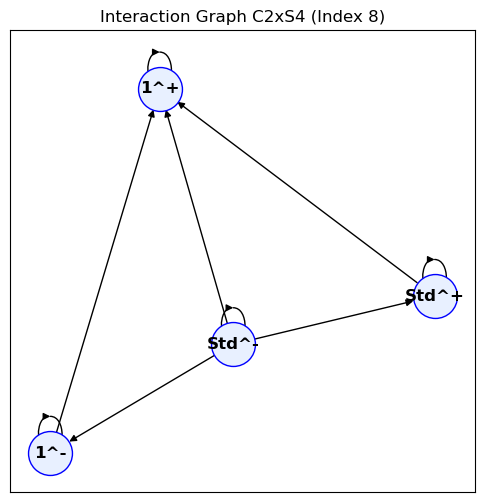

In [12]:
run_analysis()